In [1]:
import numpy as np
import pandas as pd
import re
from pathlib import Path

In [2]:
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
raw_path = Path('../data/raw')
interim_path = Path('../data/interim')

In [4]:
df = pd.read_csv(interim_path / 'properties_cleaned_v1.csv')

In [5]:
df.shape

(5933, 18)

In [6]:
df.duplicated().sum()

0

In [7]:
df.head(1)
# focus is on -> areaWithType, additionalRoom, agePossession, furnishDetails, features 

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id
0,house,independent,gurukul,2.4,11111.0,2160.0,Plot area 240(200.67 sq.m.),3,3,3,"store room,pooja room",3.0,North,1 to 5 Year Old,"['Kalpyan Pushti Haveli', 'Gurukul', 'Manav Ma...",NaN,"['Private Garden / Terrace', 'High Ceiling Hei...",V70744416


## 1. areaWithType

In [8]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
4493,1.40,1386.0,Built Up area: 238 (199 sq.m.)Carpet area: 154...
1765,1.27,2646.0,Super Built up area 2645(245.73 sq.m.)
4131,1.01,2500.0,Built Up area: 2500 (232.26 sq.m.)Carpet area:...
5273,0.59,1071.0,Carpet area: 120 (100.34 sq.m.)
327,0.90,2610.0,Built Up area: 2610 (242.48 sq.m.)


In [9]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [10]:
# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [11]:
# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [12]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [13]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1092,0.55,flat,855.0,Super Built up area 120(100.34 sq.m.)Carpet ar...,120.0,NaN,95.0
1661,3.50,house,2070.0,Plot area 240(200.67 sq.m.)Built Up area: 230 ...,NaN,230.0,NaN
4931,0.46,flat,1274.0,Carpet area: 1260 (117.06 sq.m.),NaN,NaN,1260.0
1426,1.60,flat,180.0,Built Up area: 180 (16.72 sq.m.),NaN,180.0,NaN
3687,0.79,house,800.0,Plot area 800(74.32 sq.m.)Built Up area: 1200 ...,NaN,1200.0,1000.0


In [14]:
df.duplicated().sum()

0

In [15]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(652, 7)

In [16]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,2.40,house,2160.0,Plot area 240(200.67 sq.m.),NaN,NaN,NaN
1,4.75,house,3150.0,Plot area 350(292.64 sq.m.)Built Up area: 315 ...,NaN,315.0,NaN
10,2.40,house,1305.0,Plot area 145(121.24 sq.m.)Built Up area: 215 ...,NaN,215.0,NaN
12,3.11,house,2205.0,Plot area 245(204.85 sq.m.)Built Up area: 400 ...,NaN,400.0,NaN
20,1.91,house,200.0,Plot area 200(18.58 sq.m.),NaN,NaN,NaN


In [17]:
df.isnull().sum()

property_type             0
society                   0
sector                    0
price                    11
price_per_sqft           12
area                     12
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 37
facing                 1678
agePossession             0
nearbyLocations         449
furnishDetails         2614
features               1244
property_id               0
super_built_up_area    3414
built_up_area          3925
carpet_area            2520
dtype: int64

In [18]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [19]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,2.40,house,2160.0,Plot area 240(200.67 sq.m.),NaN,NaN,NaN
20,1.91,house,200.0,Plot area 200(18.58 sq.m.),NaN,NaN,NaN
38,1.50,house,1800.0,Plot area 200(167.23 sq.m.),NaN,NaN,NaN
39,0.87,house,945.0,Plot area 105(87.79 sq.m.),NaN,NaN,NaN
45,1.90,house,1078.0,Plot area 1078(100.15 sq.m.),NaN,NaN,NaN


In [20]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [21]:
# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [22]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

# Update the original dataframe
#gurgaon_properties.update(filtered_rows)

In [23]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,2.40,house,2160.0,Plot area 240(200.67 sq.m.),NaN,240.0,NaN
20,1.91,house,200.0,Plot area 200(18.58 sq.m.),NaN,200.0,NaN
38,1.50,house,1800.0,Plot area 200(167.23 sq.m.),NaN,200.0,NaN
39,0.87,house,945.0,Plot area 105(87.79 sq.m.),NaN,105.0,NaN
45,1.90,house,1078.0,Plot area 1078(100.15 sq.m.),NaN,1078.0,NaN


In [24]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [25]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [26]:
all_nan_df.head()

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,2.40,house,2160.0,Plot area 240(200.67 sq.m.),NaN,2160.0,NaN
20,1.91,house,200.0,Plot area 200(18.58 sq.m.),NaN,200.0,NaN
38,1.50,house,1800.0,Plot area 200(167.23 sq.m.),NaN,1800.0,NaN
39,0.87,house,945.0,Plot area 105(87.79 sq.m.),NaN,945.0,NaN
45,1.90,house,1078.0,Plot area 1078(100.15 sq.m.),NaN,1078.0,NaN


In [27]:
# update the original dataframe
df.update(all_nan_df)

In [28]:
df.isnull().sum()

property_type             0
society                   0
sector                    0
price                    11
price_per_sqft           12
area                     12
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 37
facing                 1678
agePossession             0
nearbyLocations         449
furnishDetails         2614
features               1244
property_id               0
super_built_up_area    3414
built_up_area          3409
carpet_area            2520
dtype: int64

In [29]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area
0,house,independent,gurukul,2.40,11111.0,2160.0,Plot area 240(200.67 sq.m.),3,3,3,"store room,pooja room",3.0,North,1 to 5 Year Old,"['Kalpyan Pushti Haveli', 'Gurukul', 'Manav Ma...",NaN,"['Private Garden / Terrace', 'High Ceiling Hei...",V70744416,NaN,2160.0,NaN
1,house,omkar bunglows,thaltej,4.75,15079.0,3150.0,Plot area 350(292.64 sq.m.)Built Up area: 315 ...,4,4,1,"store room,pooja room",2.0,East,10+ Year Old,"['Bhagwat Vidyapeeth', 'ambe mataa mandir', 'B...","['1 Water Purifier', '4 Fan', '1 Exhaust Fan',...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",F64661686,NaN,315.0,NaN
2,flat,sheeva amardeep enclave,nava naroda,0.27,21600.0,125.0,Built Up area: 125 (11.61 sq.m.)Carpet area: 1...,2,2,1,not available,3.0,NaN,undefined,"['Uma Maternity and Nursing Home', 'Priyal Hos...",NaN,NaN,C69857732,NaN,125.0,115.0
3,flat,arizona river heights,usmanpura,2.10,8909.0,2357.0,Super Built up area 2357(218.97 sq.m.)Carpet a...,3,3,2,"pooja room,others",11.0,East,5 to 10 Year Old,"['Aalap Clinic and Surgical Nursing Home', 'Kr...","['1 Water Purifier', '1 Fridge', '6 Fan', '1 E...","['Security / Fire Alarm', 'Intercom Facility',...",H69328788,2357.0,NaN,1415.0
4,flat,avirat silver harmony,gota,0.98,4839.0,2025.0,Super Built up area 2025(188.13 sq.m.),3,3,1,store room,9.0,East,5 to 10 Year Old,"['CHANDLODIA MARKET', 'Chandlodiya Temple', 'B...",NaN,"['Feng Shui / Vaastu Compliant', 'Security / F...",G67650748,2025.0,NaN,NaN


## 2.additionalRoom

In [30]:
df['additionalRoom'].value_counts().head()

not available                       2706
store room                           832
others                               448
pooja room                           295
pooja room,study room,store room     227
Name: additionalRoom, dtype: int64

In [31]:
# additional room
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [32]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
774,"pooja room,study room",1,0,0,1,0
107,not available,0,0,0,0,0
4868,"pooja room,store room,study room",1,0,1,1,0
5295,store room,0,0,1,0,0
4145,study room,1,0,0,0,0


In [33]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,house,independent,gurukul,2.40,11111.0,2160.0,Plot area 240(200.67 sq.m.),3,3,3,"store room,pooja room",3.0,North,1 to 5 Year Old,"['Kalpyan Pushti Haveli', 'Gurukul', 'Manav Ma...",NaN,"['Private Garden / Terrace', 'High Ceiling Hei...",V70744416,NaN,2160.0,NaN,0,0,1,1,0
1,house,omkar bunglows,thaltej,4.75,15079.0,3150.0,Plot area 350(292.64 sq.m.)Built Up area: 315 ...,4,4,1,"store room,pooja room",2.0,East,10+ Year Old,"['Bhagwat Vidyapeeth', 'ambe mataa mandir', 'B...","['1 Water Purifier', '4 Fan', '1 Exhaust Fan',...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",F64661686,NaN,315.0,NaN,0,0,1,1,0
2,flat,sheeva amardeep enclave,nava naroda,0.27,21600.0,125.0,Built Up area: 125 (11.61 sq.m.)Carpet area: 1...,2,2,1,not available,3.0,NaN,undefined,"['Uma Maternity and Nursing Home', 'Priyal Hos...",NaN,NaN,C69857732,NaN,125.0,115.0,0,0,0,0,0
3,flat,arizona river heights,usmanpura,2.10,8909.0,2357.0,Super Built up area 2357(218.97 sq.m.)Carpet a...,3,3,2,"pooja room,others",11.0,East,5 to 10 Year Old,"['Aalap Clinic and Surgical Nursing Home', 'Kr...","['1 Water Purifier', '1 Fridge', '6 Fan', '1 E...","['Security / Fire Alarm', 'Intercom Facility',...",H69328788,2357.0,NaN,1415.0,0,0,0,1,1
4,flat,avirat silver harmony,gota,0.98,4839.0,2025.0,Super Built up area 2025(188.13 sq.m.),3,3,1,store room,9.0,East,5 to 10 Year Old,"['CHANDLODIA MARKET', 'Chandlodiya Temple', 'B...",NaN,"['Feng Shui / Vaastu Compliant', 'Security / F...",G67650748,2025.0,NaN,NaN,0,0,1,0,0


## 3.agePossession

In [34]:
df['agePossession'].value_counts().sample(10)

Nov-23               1
Dec 2027            10
Feb 2025             1
Apr-24               2
Jan-24               3
Within 3 months     23
undefined          507
Jul-24               6
Dec-25               9
Dec 2025           127
Name: agePossession, dtype: int64

In [35]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

In [36]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [37]:
df['agePossession'].value_counts()

Relatively New        1814
Moderately Old        1280
Old Property          1076
Under Construction     675
Undefined              552
New Property           536
Name: agePossession, dtype: int64

In [38]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,house,independent,gurukul,2.40,11111.0,2160.0,Plot area 240(200.67 sq.m.),3,3,3,"store room,pooja room",3.0,North,Relatively New,"['Kalpyan Pushti Haveli', 'Gurukul', 'Manav Ma...",NaN,"['Private Garden / Terrace', 'High Ceiling Hei...",V70744416,NaN,2160.0,NaN,0,0,1,1,0
1,house,omkar bunglows,thaltej,4.75,15079.0,3150.0,Plot area 350(292.64 sq.m.)Built Up area: 315 ...,4,4,1,"store room,pooja room",2.0,East,Old Property,"['Bhagwat Vidyapeeth', 'ambe mataa mandir', 'B...","['1 Water Purifier', '4 Fan', '1 Exhaust Fan',...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",F64661686,NaN,315.0,NaN,0,0,1,1,0
2,flat,sheeva amardeep enclave,nava naroda,0.27,21600.0,125.0,Built Up area: 125 (11.61 sq.m.)Carpet area: 1...,2,2,1,not available,3.0,NaN,Undefined,"['Uma Maternity and Nursing Home', 'Priyal Hos...",NaN,NaN,C69857732,NaN,125.0,115.0,0,0,0,0,0
3,flat,arizona river heights,usmanpura,2.10,8909.0,2357.0,Super Built up area 2357(218.97 sq.m.)Carpet a...,3,3,2,"pooja room,others",11.0,East,Moderately Old,"['Aalap Clinic and Surgical Nursing Home', 'Kr...","['1 Water Purifier', '1 Fridge', '6 Fan', '1 E...","['Security / Fire Alarm', 'Intercom Facility',...",H69328788,2357.0,NaN,1415.0,0,0,0,1,1
4,flat,avirat silver harmony,gota,0.98,4839.0,2025.0,Super Built up area 2025(188.13 sq.m.),3,3,1,store room,9.0,East,Moderately Old,"['CHANDLODIA MARKET', 'Chandlodiya Temple', 'B...",NaN,"['Feng Shui / Vaastu Compliant', 'Security / F...",G67650748,2025.0,NaN,NaN,0,0,1,0,0


## 4.furnishDetails

In [39]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
4185,"['5 Fan', '5 Light', '1 Curtains', 'No AC', 'N...","['Power Back-up', 'Feng Shui / Vaastu Complian..."
1468,"['1 Water Purifier', '4 Fan', '1 Fridge', '1 E...","['Water purifier', 'Park', 'Piped-gas', 'Visit..."
2949,"['1 Water Purifier', '4 Fan', '1 Fridge', '1 D...","['Feng Shui / Vaastu Compliant', 'Security / F..."
9,NaN,"['Feng Shui / Vaastu Compliant', 'Security / F..."
4289,"['1 Water Purifier', '5 Fan', '1 Exhaust Fan',...","['Security / Fire Alarm', 'Feng Shui / Vaastu ..."


In [40]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]


In [41]:
furnishings_df.shape

(5933, 19)

In [42]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

C:\Users\Arpit\AppData\Local\Temp\ipykernel_7512\114705885.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [43]:
furnishings_df.sample(5)

,Bed,Geyser,Sofa,Water Purifier,Stove,Microwave,TV,AC,Chimney,Exhaust Fan,Wardrobe,Light,Modular Kitchen,Curtains,Dining Table,Fan,Fridge,Washing Machine
5424,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4983,0,3,1,1,1,0,1,4,1,1,3,5,1,7,1,5,1,0
2406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
848,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [45]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [46]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42,n_init=10)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

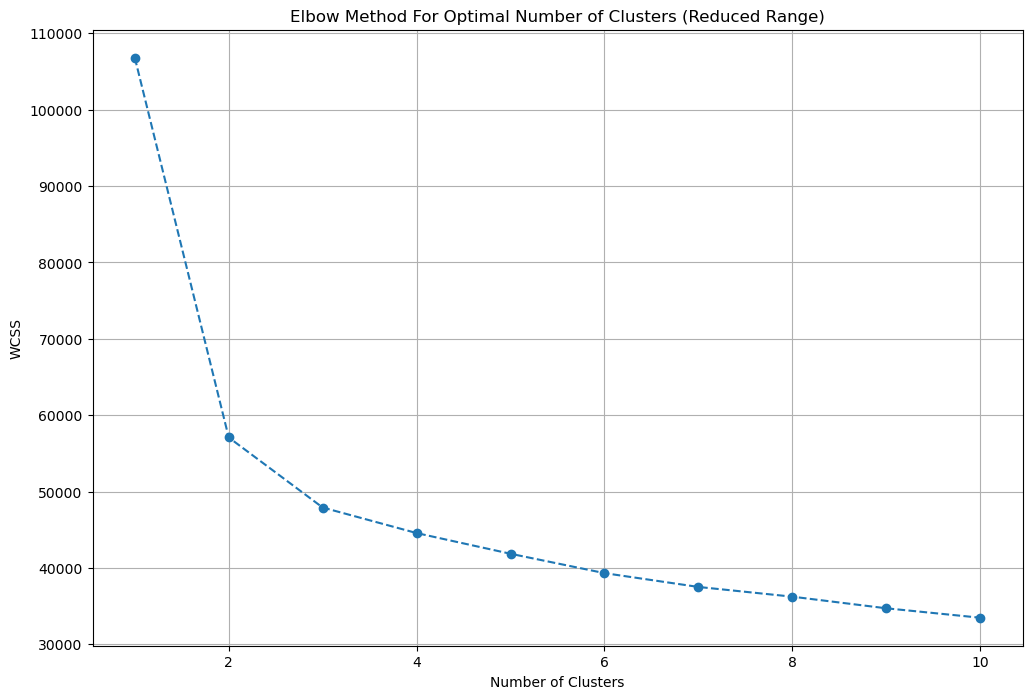

In [47]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [48]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [49]:
df = df.iloc[:,:-18]

In [50]:
df['furnishing_type'] = cluster_assignments

In [51]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
2513,"['1 Water Purifier', '1 Fridge', '6 Fan', '1 E...",1
5356,NaN,0
2518,"['1 Bed', '1 Wardrobe', '2 Fan', '1 Sofa', '1 ...",2
196,"['1 Wardrobe', '3 Fan', '5 Light', '1 Modular ...",0
5844,NaN,0


## 5.features

In [52]:
df[['society','features']].sample(5)

,society,features
2988,associated sahaj century,"['Lift(s)', 'High Ceiling Height', 'Maintenanc..."
5335,savaliya krish elite,"['Security / Fire Alarm', 'Intercom Facility',..."
2400,swati residency 4,NaN
1193,sky city arcade,"['Centrally Air Conditioned', 'Water purifier'..."
3384,shaligram prime,"['Water purifier', 'Security / Fire Alarm', 'F..."


In [53]:
df['features'].isnull().sum()

1244

In [54]:
app_df = pd.read_csv(raw_path / 'appartments.csv')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Atithi Elegance,"2, 3 BHK Apartment in Narol, Ahmedabad East","['Rahe Public School', 'State Bank of India', ...","{'Rahe Public School': '240 WITHIN M', 'State ...",https://www.99acres.com/atithi-elegance-narol-...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Car wash area', 'Swimming Pool', 'Sun Deck',..."
1,Sattvam Icon,"2 BHK Apartment in Vatva, Ahmedabad East","['NH47', 'Aviraj Pinnacle', 'Vedant Internatio...","{'NH47': '1.6 KM', 'Aviraj Pinnacle': '3.7 K...",https://www.99acres.com/sattvam-icon-vatva-ahm...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Solar Lighting', 'Piped Gas', 'Gazebo', 'CCT..."


In [55]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [56]:
temp_df = df[df['features'].isnull()]

In [57]:
temp_df.shape

(1244, 27)

In [58]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [59]:
df.loc[temp_df.index,'features'] = x.values

In [60]:
df['features'].isnull().sum()

1220

In [61]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [62]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [63]:
features_binary_df.sample(5)

,24/7 Power Backup,24x7 Security,ATM,Airy Rooms,Amphitheatre,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Billiards,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Centrally Air Conditioned,Changing Area,Children's Play Area,Club House,Club house / Community Center,Community Hall,Creche/Day care,Cricket Pitch,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fitness Centre / GYM,Football,Gated Community,Gazebo,Gymnasium,High Ceiling Height,Indoor Games,Intercom Facility,Internet/wi-fi connectivity,Landscape Garden,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Medical Centre,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,No open drainage around,Park,Party Lawn,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Rain Water Harvesting,Recently Renovated,Reflexology Park,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Shopping Centre,Skating Rink,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Table Tennis,Temple,Theater Home,Vastu Compliant,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Storage,Water purifier,Water softening plant,Yoga/Meditation Area
312,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5161,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0
227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
417,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [64]:
temp_features = features_binary_df.columns.to_list()

In [65]:
features_binary_df.shape

(5933, 84)

In [66]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

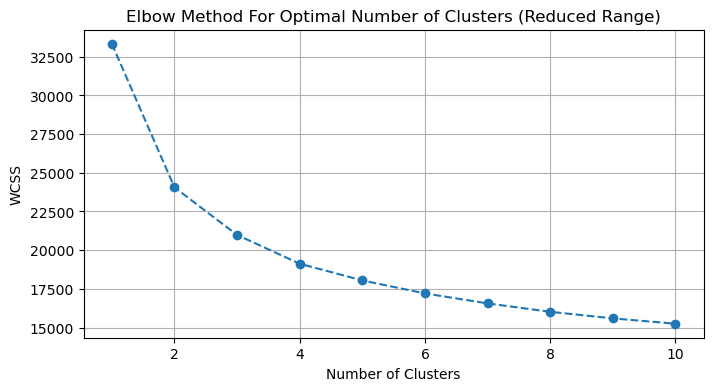

In [67]:
# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [68]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    'Airy Rooms': 9,
    'Bank Attached Property': 6,
    'Centrally Air Conditioned': 8,
    'Club house / Community Center': 7,
    'False Ceiling Lighting': 8,
    'Feng Shui / Vaastu Compliant': 7,
    'Fitness Centre / GYM': 9,
    'High Ceiling Height': 8,
    'Intercom Facility': 7,
    'Internet/wi-fi connectivity': 9,
    'Lift(s)': 9,
    'Low Density Society': 8,
    'Maintenance Staff': 6,
    'Natural Light': 9,
    'No open drainage around': 10,
    'Park': 8,
    'Piped-gas': 9,
    'Power Back-up': 9,
    'Private Garden / Terrace': 8,
    'Rain Water Harvesting': 9,
    'Recently Renovated': 7,
    'Security / Fire Alarm': 8,
    'Security Personnel': 9,
    'Separate entry for servant room': 7,
    'Shopping Centre': 8,
    'Spacious Interiors': 9,
    'Swimming Pool': 9,
    'Visitor Parking': 8,
    'Waste Disposal': 9,
    'Water Storage': 8,
    'Water purifier': 9,
    'Water softening plant': 8
}

# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)


In [69]:
df['luxury_score'] = luxury_score

In [70]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,property_id,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,house,independent,gurukul,2.40,11111.0,2160.0,Plot area 240(200.67 sq.m.),3,3,3,"store room,pooja room",3.0,North,Relatively New,"['Kalpyan Pushti Haveli', 'Gurukul', 'Manav Ma...",NaN,"['Private Garden / Terrace', 'High Ceiling Hei...",V70744416,NaN,2160.0,NaN,0,0,1,1,0,0,"[Private Garden / Terrace, High Ceiling Height...",86
1,house,omkar bunglows,thaltej,4.75,15079.0,3150.0,Plot area 350(292.64 sq.m.)Built Up area: 315 ...,4,4,1,"store room,pooja room",2.0,East,Old Property,"['Bhagwat Vidyapeeth', 'ambe mataa mandir', 'B...","['1 Water Purifier', '4 Fan', '1 Exhaust Fan',...","['Security / Fire Alarm', 'Feng Shui / Vaastu ...",F64661686,NaN,315.0,NaN,0,0,1,1,0,1,"[Security / Fire Alarm, Feng Shui / Vaastu Com...",161
2,flat,sheeva amardeep enclave,nava naroda,0.27,21600.0,125.0,Built Up area: 125 (11.61 sq.m.)Carpet area: 1...,2,2,1,not available,3.0,NaN,Undefined,"['Uma Maternity and Nursing Home', 'Priyal Hos...",NaN,NaN,C69857732,NaN,125.0,115.0,0,0,0,0,0,0,[],0
3,flat,arizona river heights,usmanpura,2.10,8909.0,2357.0,Super Built up area 2357(218.97 sq.m.)Carpet a...,3,3,2,"pooja room,others",11.0,East,Moderately Old,"['Aalap Clinic and Surgical Nursing Home', 'Kr...","['1 Water Purifier', '1 Fridge', '6 Fan', '1 E...","['Security / Fire Alarm', 'Intercom Facility',...",H69328788,2357.0,NaN,1415.0,0,0,0,1,1,1,"[Security / Fire Alarm, Intercom Facility, Lif...",54
4,flat,avirat silver harmony,gota,0.98,4839.0,2025.0,Super Built up area 2025(188.13 sq.m.),3,3,1,store room,9.0,East,Moderately Old,"['CHANDLODIA MARKET', 'Chandlodiya Temple', 'B...",NaN,"['Feng Shui / Vaastu Compliant', 'Security / F...",G67650748,2025.0,NaN,NaN,0,0,1,0,0,0,"[Feng Shui / Vaastu Compliant, Security / Fire...",75


In [71]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom','property_id'],inplace=True)

In [72]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
871,flat,narayan crystal,vatva,0.22,2628.0,837.0,Super Built up area 837(77.76 sq.m.),2,2,1,3.0,NaN,Moderately Old,837.0,NaN,NaN,0,0,0,0,0,0,0
675,house,independent,nikol,0.30,6636.0,452.0,Plot area 42,2,2,1,2.0,North-West,Old Property,NaN,449.4,NaN,0,0,0,0,0,0,0
823,flat,shanti shukra,narol,0.16,2539.0,630.0,Super Built up area 630(58.53 sq.m.),1,1,1,6.0,South-West,Relatively New,630.0,NaN,NaN,0,0,0,0,0,0,74
1981,flat,satatya avenue,new ranip,0.27,4000.0,675.0,Super Built up area 75(62.71 sq.m.)Built Up ar...,2,2,1,4.0,North-West,Relatively New,75.0,65.0,60.0,0,0,0,0,1,2,0
2147,flat,shital varsha 2,usmanpura,1.15,6122.0,1878.0,Super Built up area 245(204.85 sq.m.),4,3,1,4.0,West,Old Property,245.0,NaN,NaN,0,0,0,0,1,1,31


In [73]:
df.shape

(5933, 23)

In [74]:
df.to_csv(interim_path / 'properties_cleaned_v2.csv',index=False)